In [1]:
%matplotlib inline
import pandas as pd
import missingno as msno
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA
import seaborn as sns
from termcolor import colored
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings("ignore")

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
train_path = "dataset/train.csv"
test_path = "dataset/test.csv"
target_path = "dataset/gender_submission.csv"

train_set = pd.read_csv(train_path)
test_set = pd.read_csv(test_path)
y_test = pd.read_csv(target_path)

In [3]:
y_train = train_set["Survived"]

In [4]:
y_test = y_test["Survived"]

In [5]:
train_set.shape,test_set.shape

((891, 12), (418, 11))

In [6]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
train_set.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
train_set.tail(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
881,882,0,3,"Markun, Mr. Johann",male,33.0,0,0,349257,7.8958,NaN,S
882,883,0,3,"Dahlberg, Miss. Gerda Ulrika",female,22.0,0,0,7552,10.5167,NaN,S
883,884,0,2,"Banfield, Mr. Frederick James",male,28.0,0,0,C.A./SOTON 34068,10.5000,NaN,S
884,885,0,3,"Sutehall, Mr. Henry Jr",male,25.0,0,0,SOTON/OQ 392076,7.0500,NaN,S
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.7500,NaN,Q


In [9]:
train_set["Cabin"].value_counts()

Cabin
B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: count, Length: 147, dtype: int64

In [10]:
train_set["Survived"].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

In [11]:
train_cpy = train_set.copy()
test_cpy = test_set.copy()

train_cpy.drop(["Cabin", "PassengerId", "Name", "Survived"], axis=1, inplace=True)
test_cpy.drop(["Cabin", "PassengerId", "Name"], axis=1, inplace=True)

In [12]:
train_cpy.head(5)

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,3,male,22.0,1,0,A/5 21171,7.2500,S
1,1,female,38.0,1,0,PC 17599,71.2833,C
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,1,female,35.0,1,0,113803,53.1000,S
4,3,male,35.0,0,0,373450,8.0500,S


In [13]:
test_cpy.head(2)

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,3,male,34.5,0,0,330911,7.8292,Q
1,3,female,47.0,1,0,363272,7.0000,S


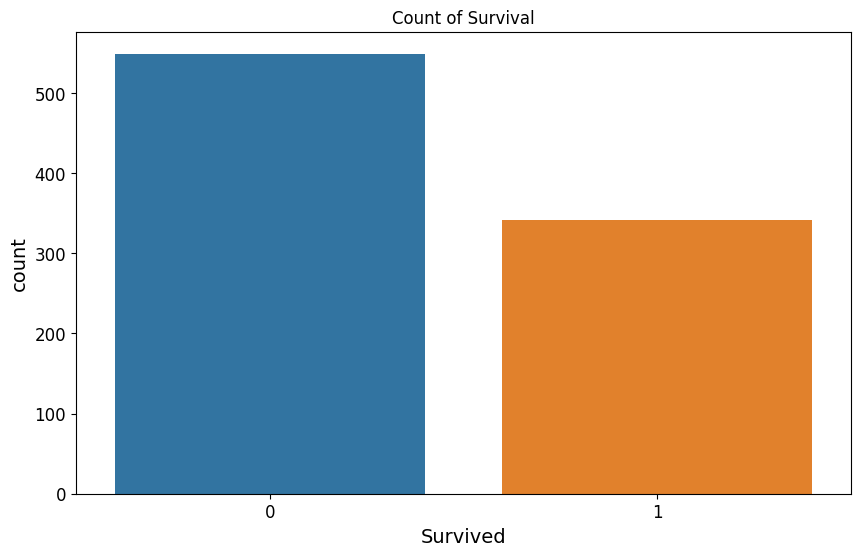

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.countplot(x='Survived', data=train_set)
plt.title("Count of Survival")
plt.show()

<Axes: >

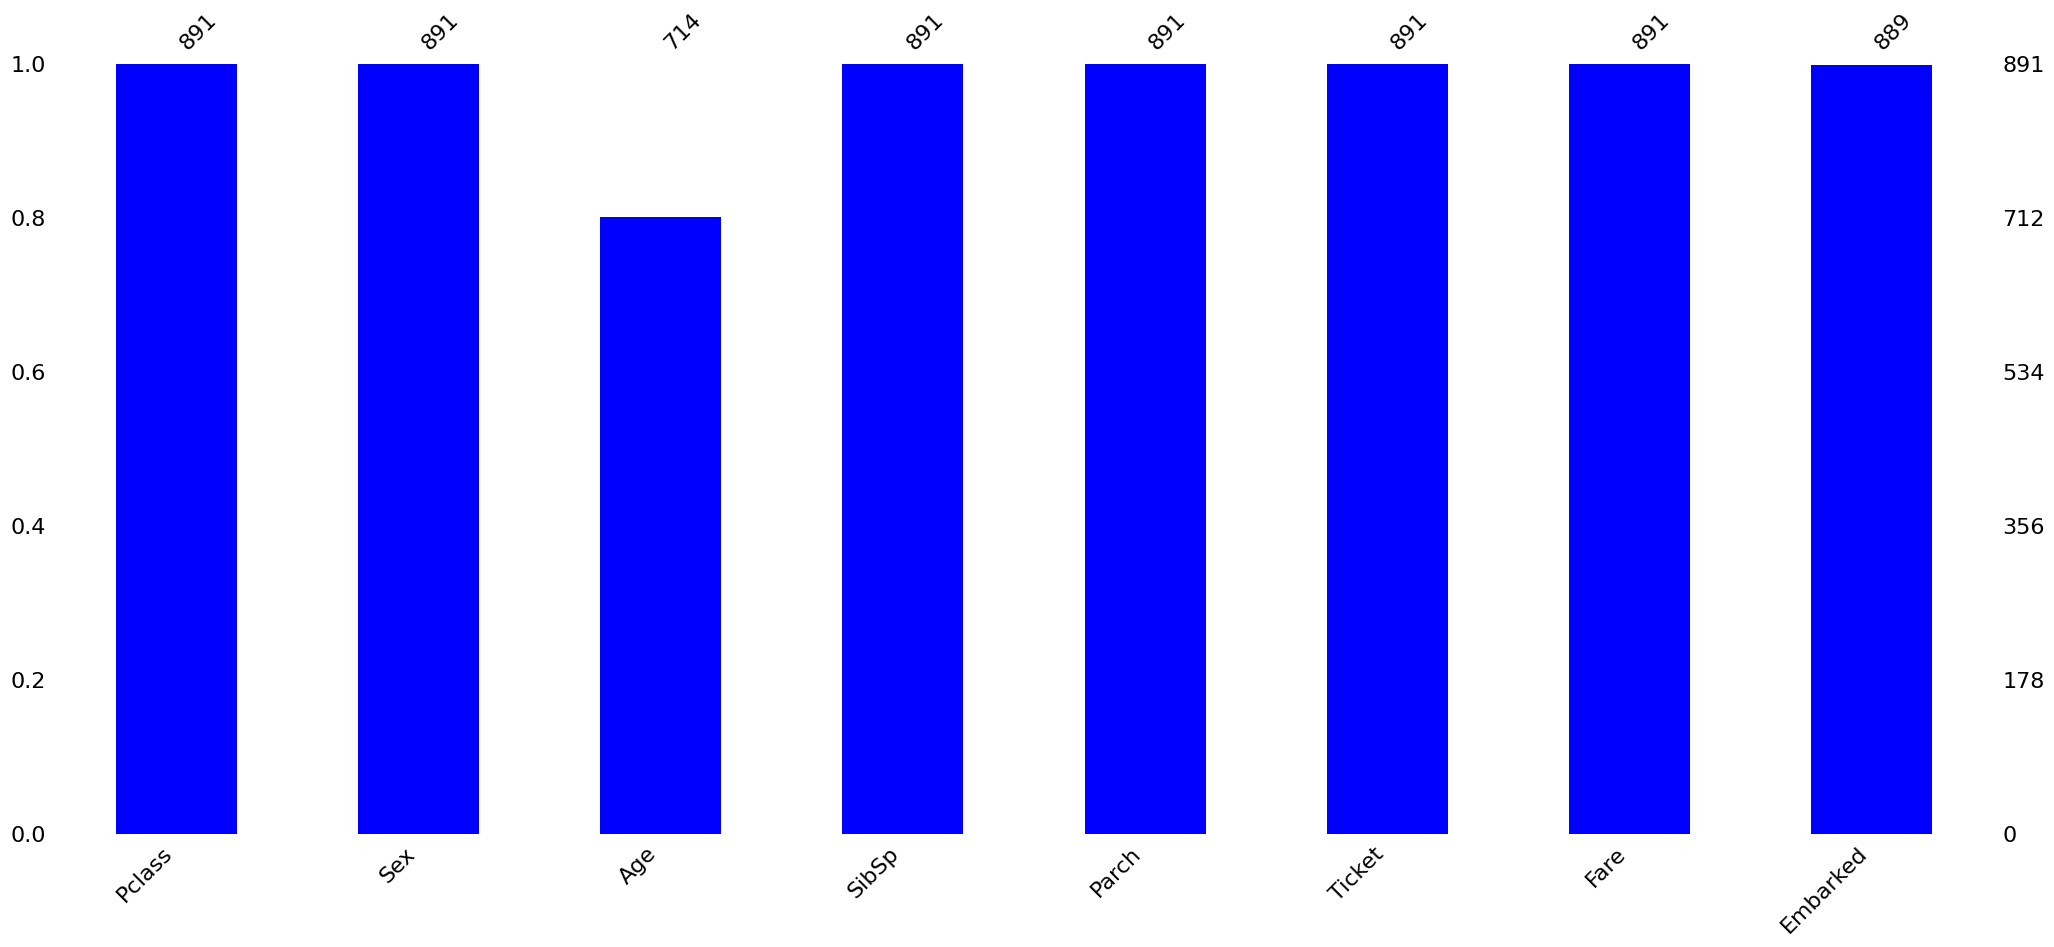

In [15]:
msno.bar(train_cpy,color='b')

In [16]:
train_cpy[train_cpy["Sex"]=="female"].isna().sum()

Pclass       0
Sex          0
Age         53
SibSp        0
Parch        0
Ticket       0
Fare         0
Embarked     2
dtype: int64

In [17]:
train_cpy[train_cpy["Sex"]=="male"].isna().sum()

Pclass        0
Sex           0
Age         124
SibSp         0
Parch         0
Ticket        0
Fare          0
Embarked      0
dtype: int64

In [18]:
females_age_median = train_cpy[train_cpy["Sex"] == "female"]["Age"].median()

train_cpy.loc[train_set["Sex"] == "female","Age"] = train_cpy.loc[train_set['Sex'] == 'female', 'Age'].fillna(females_age_median)

In [19]:
train_cpy[train_cpy["Sex"]=="female"].isna().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Embarked    2
dtype: int64

In [20]:
train_cpy[train_cpy["Sex"]=="male"].isna().sum()

Pclass        0
Sex           0
Age         124
SibSp         0
Parch         0
Ticket        0
Fare          0
Embarked      0
dtype: int64

In [21]:
males_age_median = train_cpy[train_cpy["Sex"] == "male"]["Age"].median()

train_cpy.loc[train_set["Sex"] == "male","Age"] = train_cpy.loc[train_set['Sex'] == 'male', 'Age'].fillna(males_age_median)

In [22]:
train_cpy.tail(3)

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
888,3,female,27.0,1,2,W./C. 6607,23.45,S
889,1,male,26.0,0,0,111369,30.00,C
890,3,male,32.0,0,0,370376,7.75,Q


In [23]:
train_cpy["Age"].isna().sum()

0

In [24]:
train_cpy.isna().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Embarked    2
dtype: int64

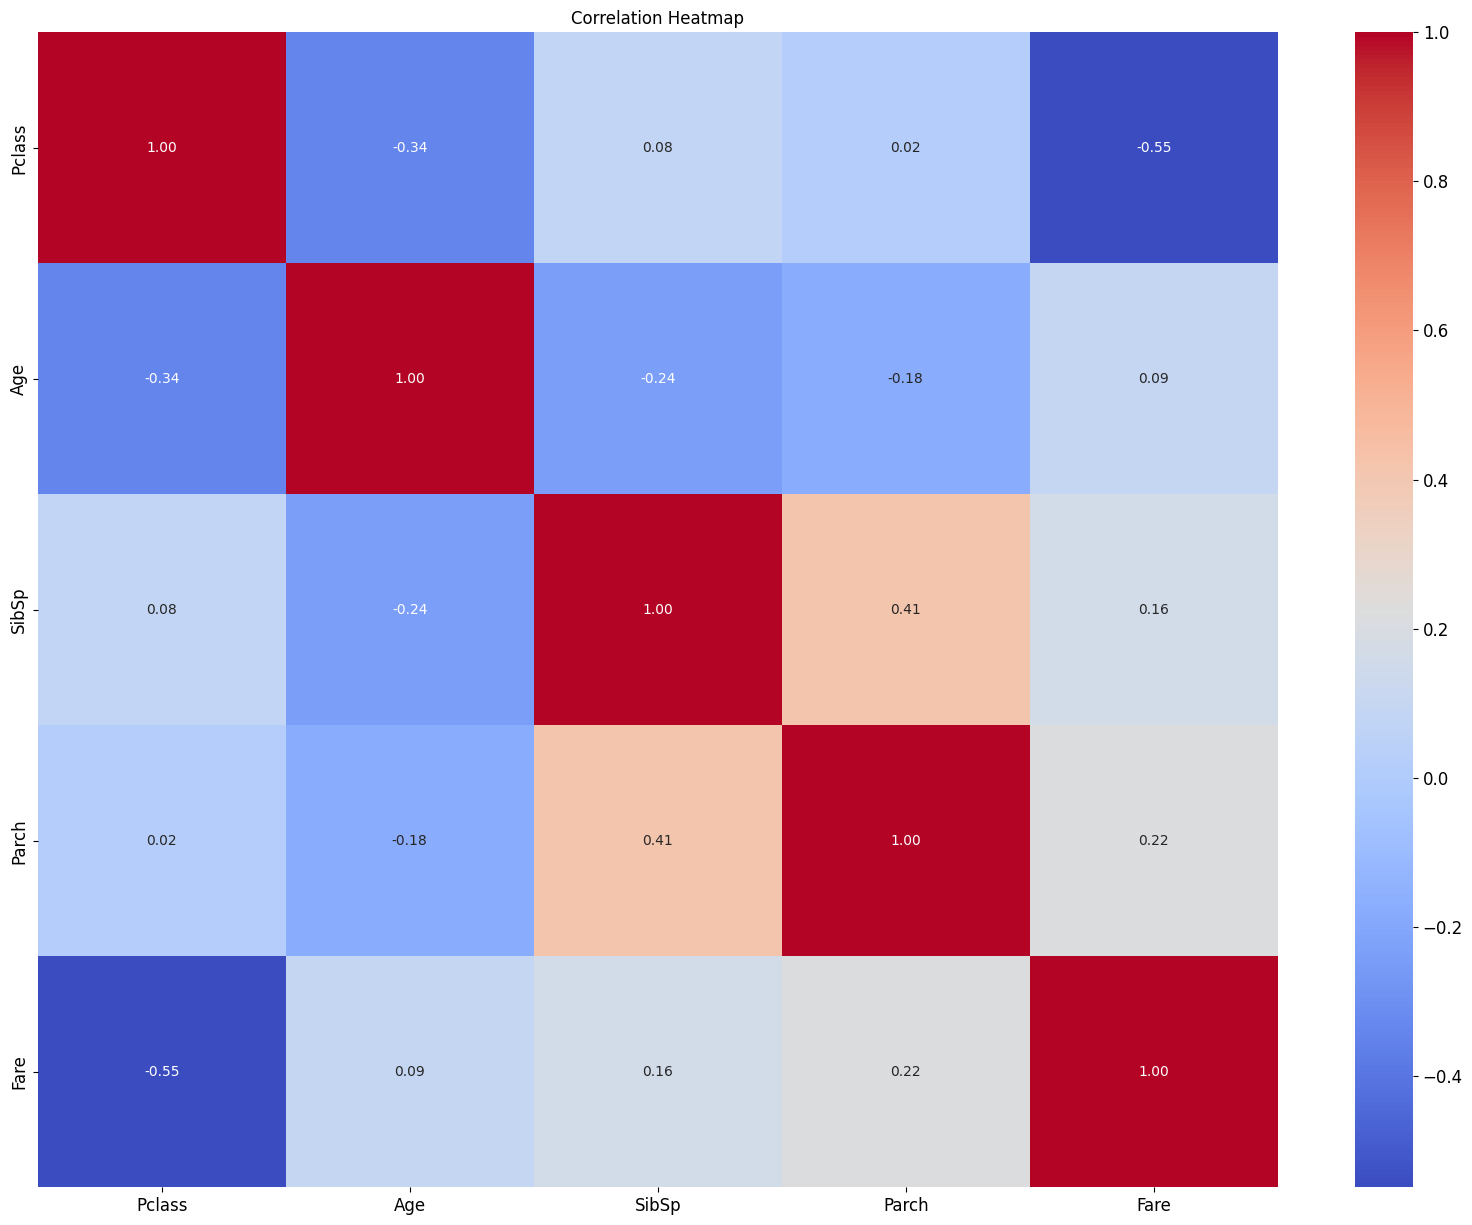

In [25]:
corr_mat = train_cpy.drop(["Sex", "Ticket", "Embarked"],axis=1).corr()

plt.figure(figsize=(20, 15))
sns.heatmap(corr_mat, annot=True,fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [26]:
train_cpy["Embarked"].duplicated().sum()

887

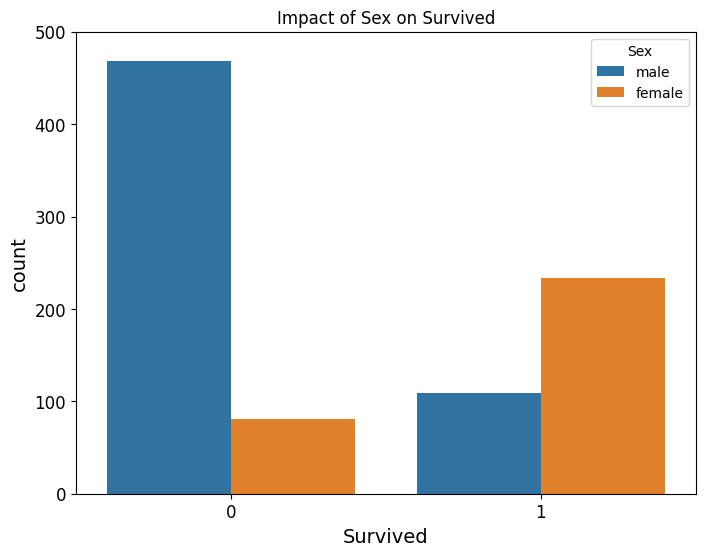

In [27]:
fig, ax=plt.subplots(figsize=(8,6))
sns.countplot(x='Survived', data=train_set, hue='Sex')
ax.set_ylim(0,500)
plt.title("Impact of Sex on Survived")
plt.show()

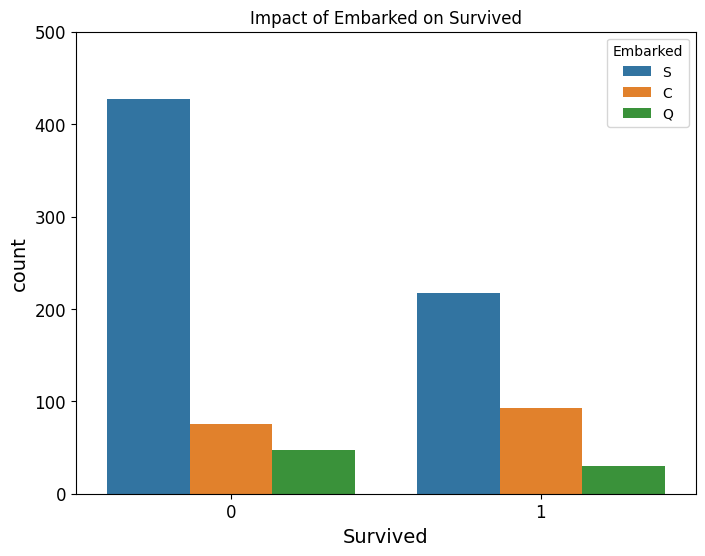

In [28]:
fig, ax=plt.subplots(figsize=(8,6))
sns.countplot(x='Survived', data=train_set, hue='Embarked')
ax.set_ylim(0,500)
plt.title("Impact of Embarked on Survived")
plt.show()

In [29]:
train_cpy["Ticket"].value_counts()

Ticket
347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: count, Length: 681, dtype: int64

In [30]:
numerical_cols = ["Age", "SibSp", "Parch", "Fare"]
categorical_cols = ["Sex", "Pclass", "Embarked"]

numerical_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

pipeline_ = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
])

X_train = pipeline_.fit_transform(train_cpy[numerical_cols + categorical_cols])

In [31]:
X_train.shape

(891, 12)

In [32]:
X_train[0]

array([-0.571902  ,  0.43279337, -0.47367361, -0.50244517,  0.        ,
        1.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  1.        ])

In [33]:
X_test = pipeline_.transform(test_set[numerical_cols + categorical_cols])

In [34]:
X_test.shape

(418, 12)

In [35]:
def eval_(model, X_train, y_train, X_test, y_test):
    print(model.__class__.__name__)
    model.fit(X_train, y_train)
    accuracy_scores = cross_val_score(model, X_train, y_train, scoring="accuracy", cv=3, n_jobs=-1)
    print(f"Accuracy scores mean = {accuracy_scores.mean()}")
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_accuracy = accuracy_score(y_train_pred, y_train)
    test_accuracy = accuracy_score(y_test_pred, y_test)
    print("Accuracy On Train set =", colored(train_accuracy,"yellow"))
    print("Accuracy On Test set =", colored(test_accuracy,"green"))
    print(100*"-")
    print(classification_report(y_test_pred, y_test))
    conf_matrix = confusion_matrix(y_test_pred, y_test)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, cmap="coolwarm", fmt=".0f")
    plt.title("Confusion Matrix")
    plt.show()
    
    return train_accuracy, test_accuracy

In [36]:
def search(model, search_type, param_grid, X_train, y_train, X_test, y_test, cv=3, verbose=3, scoring="accuracy"):
    grid_model = None
    
    if search_type == "grid":
        grid_model = GridSearchCV(model, param_grid, cv=cv, verbose=verbose, scoring=scoring, n_jobs=-1)
    else:
        grid_model = RandomizedSearchCV(model, param_grid, cv=cv, verbose=verbose, scoring=scoring, n_jobs=-1, random_state=42)
    
    grid_model.fit(X_train, y_train)
    print(f"Best params {grid_model.best_params_}")
    train_acc, test_acc = eval_(model, X_train, y_train, X_test, y_test)
    #return best one
    return grid_model.best_estimator_, train_acc, test_acc

RandomForestClassifier
Accuracy scores mean = 0.7934904601571269
Accuracy On Train set = 0.9775533108866442
Accuracy On Test set = 0.7942583732057417
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       270
           1       0.70      0.72      0.71       148

    accuracy                           0.79       418
   macro avg       0.77      0.78      0.78       418
weighted avg       0.80      0.79      0.79       418



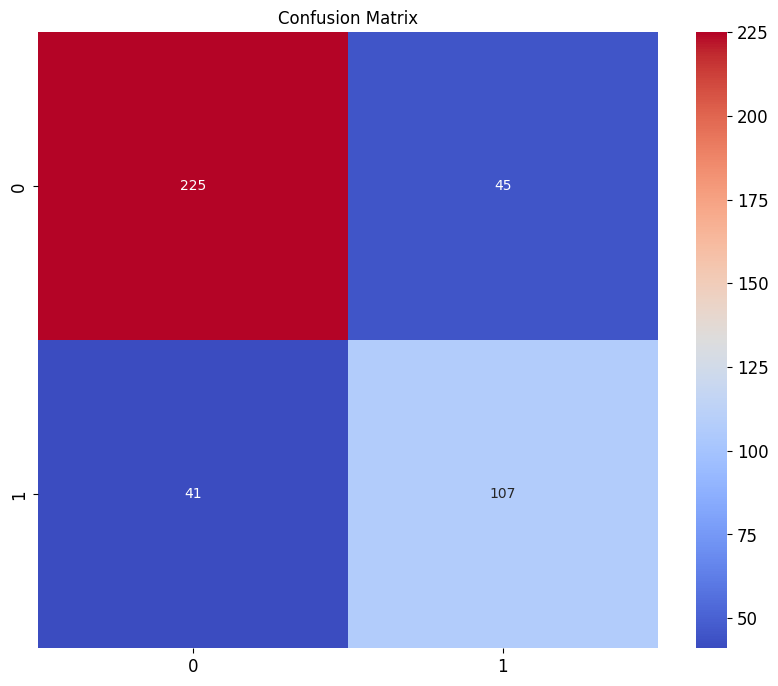

In [37]:
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)

rnd_clf_train_acc, rnd_clf_test_acc = eval_(rnd_clf, X_train, y_train, X_test, y_test)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best params {'n_estimators': 400, 'max_depth': 6}
RandomForestClassifier
Accuracy scores mean = 0.7934904601571269
Accuracy On Train set = 0.9775533108866442
Accuracy On Test set = 0.7942583732057417
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       270
           1       0.70      0.72      0.71       148

    accuracy                           0.79       418
   macro avg       0.77      0.78      0.78       418
weighted avg       0.80      0.79      0.79       418



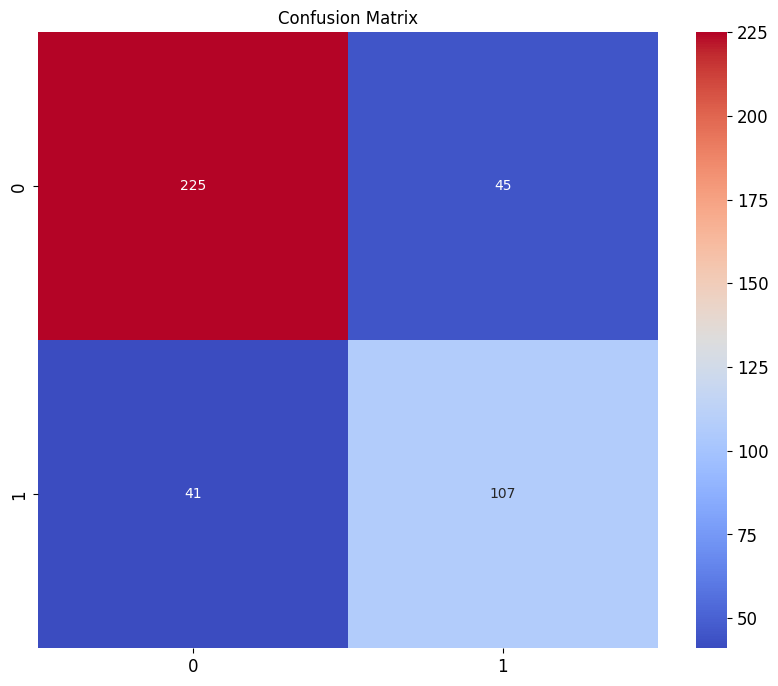

In [38]:
rnd_clf_param_grid = { 
    'n_estimators': list(range(100,500,100)),
    'max_depth' : [4,5,6,7,8],
}

best_rnd_clf, best_rnd_train_acc, best_rnd_acc = search(rnd_clf, "randomized", rnd_clf_param_grid, X_train, y_train, X_test, y_test)

DecisionTreeClassifier
Accuracy scores mean = 0.7777777777777777
Accuracy On Train set = 0.9775533108866442
Accuracy On Test set = 0.7703349282296651
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.82      0.82       262
           1       0.70      0.68      0.69       156

    accuracy                           0.77       418
   macro avg       0.75      0.75      0.75       418
weighted avg       0.77      0.77      0.77       418



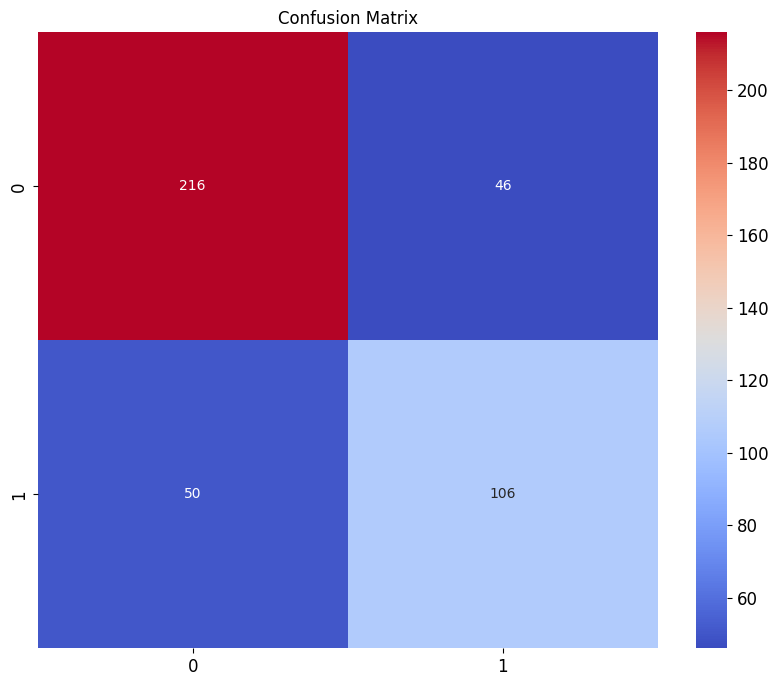

In [39]:
dtc = DecisionTreeClassifier(random_state=42)

dtc_train_acc, dtc_test_acc = eval_(dtc, X_train, y_train, X_test, y_test)

KNeighborsClassifier
Accuracy scores mean = 0.7923681257014591
Accuracy On Train set = 0.8619528619528619
Accuracy On Test set = 0.84688995215311
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.90      0.88       252
           1       0.84      0.77      0.80       166

    accuracy                           0.85       418
   macro avg       0.84      0.83      0.84       418
weighted avg       0.85      0.85      0.85       418



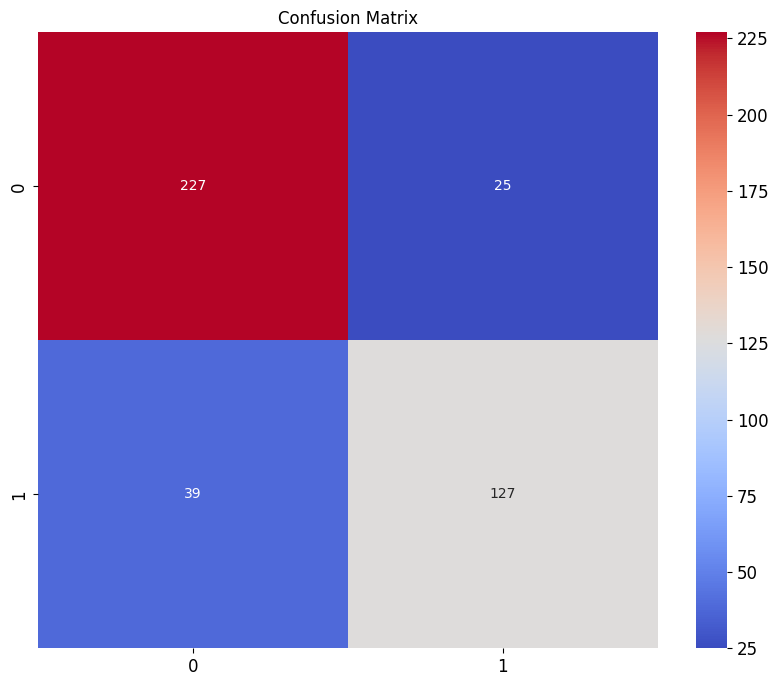

In [40]:
knn = KNeighborsClassifier(n_jobs=-1)

knn_train_acc, knn_test_acc = eval_(knn, X_train, y_train, X_test, y_test)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best params {'metric': 'manhattan', 'n_neighbors': 13, 'weights': 'uniform'}
KNeighborsClassifier
Accuracy scores mean = 0.7923681257014591
Accuracy On Train set = 0.8619528619528619
Accuracy On Test set = 0.84688995215311
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.90      0.88       252
           1       0.84      0.77      0.80       166

    accuracy                           0.85       418
   macro avg       0.84      0.83      0.84       418
weighted avg       0.85      0.85      0.85       418



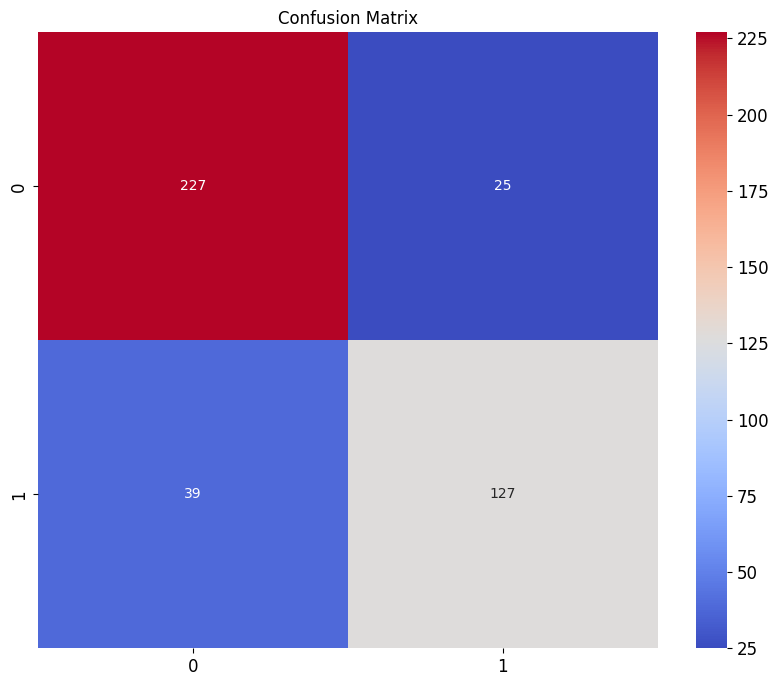

In [41]:
knn_grid = {
    'n_neighbors': list(range(3,20,2)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

best_knn, best_knn_train_acc, best_knn_acc = search(knn, "grid", knn_grid, X_train, y_train, X_test, y_test)

XGBClassifier
Accuracy scores mean = 0.8002244668911337
Accuracy On Train set = 0.9629629629629629
Accuracy On Test set = 0.8133971291866029
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.84      0.86       276
           1       0.71      0.76      0.73       142

    accuracy                           0.81       418
   macro avg       0.79      0.80      0.80       418
weighted avg       0.82      0.81      0.81       418



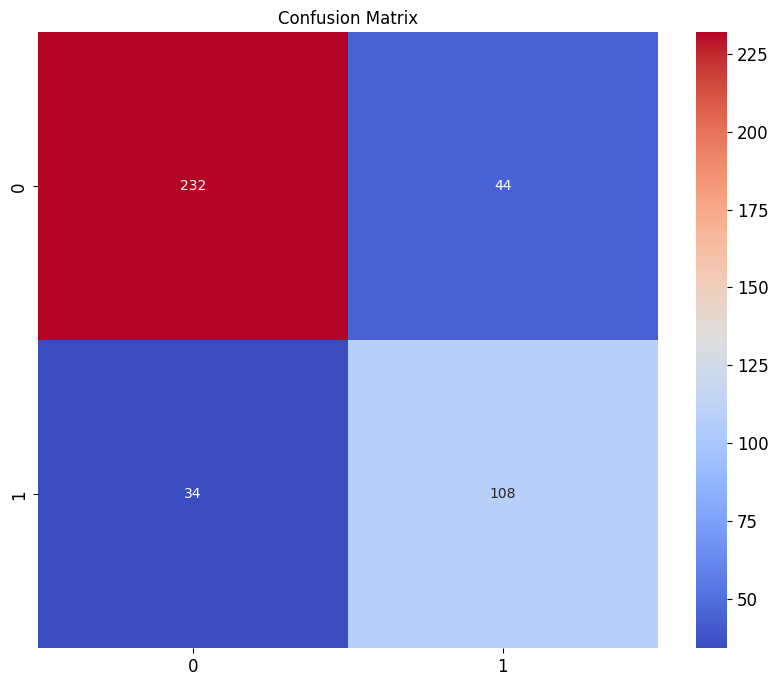

In [42]:
xgb = XGBClassifier()

xgb_train_acc, xgb_test_acc = eval_(xgb, X_train, y_train, X_test, y_test)

SVC
Accuracy scores mean = 0.8271604938271605
Accuracy On Train set = 0.8372615039281706
Accuracy On Test set = 0.9401913875598086
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       269
           1       0.91      0.93      0.92       149

    accuracy                           0.94       418
   macro avg       0.93      0.94      0.94       418
weighted avg       0.94      0.94      0.94       418



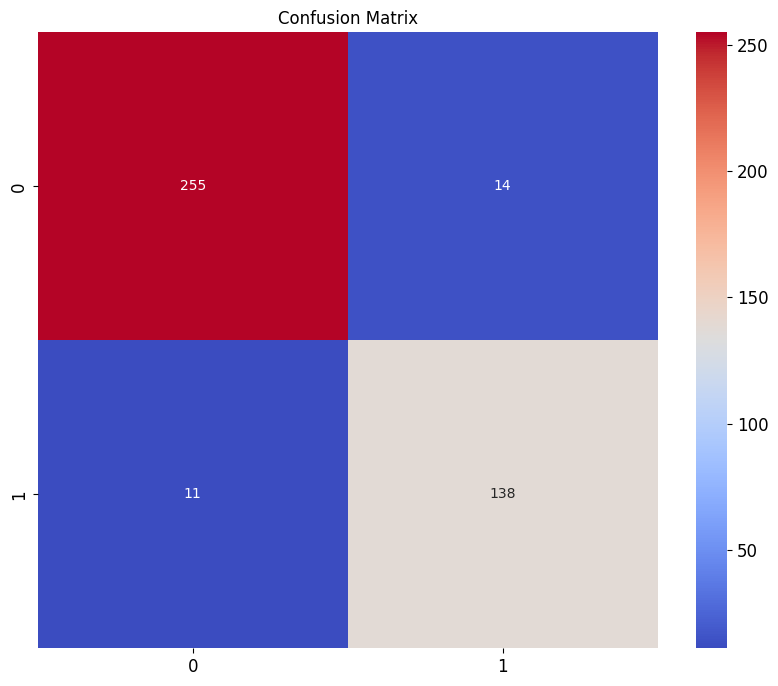

In [43]:
svc = SVC(probability=True)

#svc.fit(X_train, y_train)
#accuracy_score(svc.predict(X_test), y_test)
svc_train_acc, svc_test_acc = eval_(svc, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params {'C': 100, 'gamma': 0.01}
SVC
Accuracy scores mean = 0.8271604938271605
Accuracy On Train set = 0.8372615039281706
Accuracy On Test set = 0.9401913875598086
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       269
           1       0.91      0.93      0.92       149

    accuracy                           0.94       418
   macro avg       0.93      0.94      0.94       418
weighted avg       0.94      0.94      0.94       418



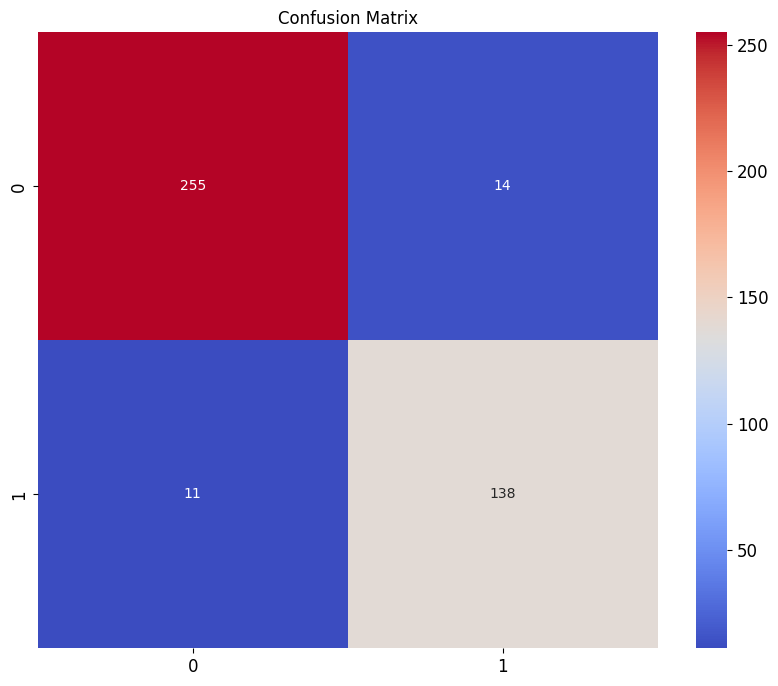

In [44]:
svc_grid_params = {
    'C': [0.1, 1, 10, 100, 1000], 
    'gamma': [0.1, 0.01, 0.001, 0.0001]                
}

best_svc, best_svc_train_acc, best_svc_test_acc = search(SVC(), "grid", svc_grid_params, X_train, y_train, X_test, y_test, cv=5)

LogisticRegression
Accuracy scores mean = 0.7912457912457912
Accuracy On Train set = 0.8069584736251403
Accuracy On Test set = 0.9449760765550239
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       265
           1       0.93      0.92      0.92       153

    accuracy                           0.94       418
   macro avg       0.94      0.94      0.94       418
weighted avg       0.94      0.94      0.94       418



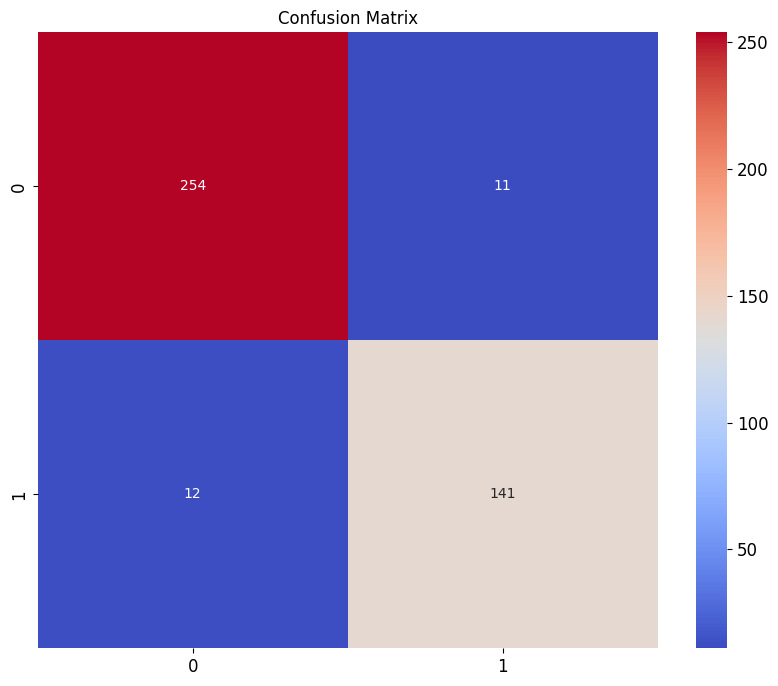

In [45]:
log_reg = LogisticRegression(n_jobs=-1, random_state=42)
#log_reg.fit(X_train, y_train)
#accuracy_score(log_reg.predict(X_test), y_test)
log_reg_train_acc, log_reg_test_acc = eval_(log_reg, X_train, y_train, X_test, y_test)

# Voting

VotingClassifier
Accuracy scores mean = 0.8136924803591471
Accuracy On Train set = 0.8237934904601572
Accuracy On Test set = 0.9593301435406698
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       279
           1       0.90      0.99      0.94       139

    accuracy                           0.96       418
   macro avg       0.95      0.97      0.96       418
weighted avg       0.96      0.96      0.96       418



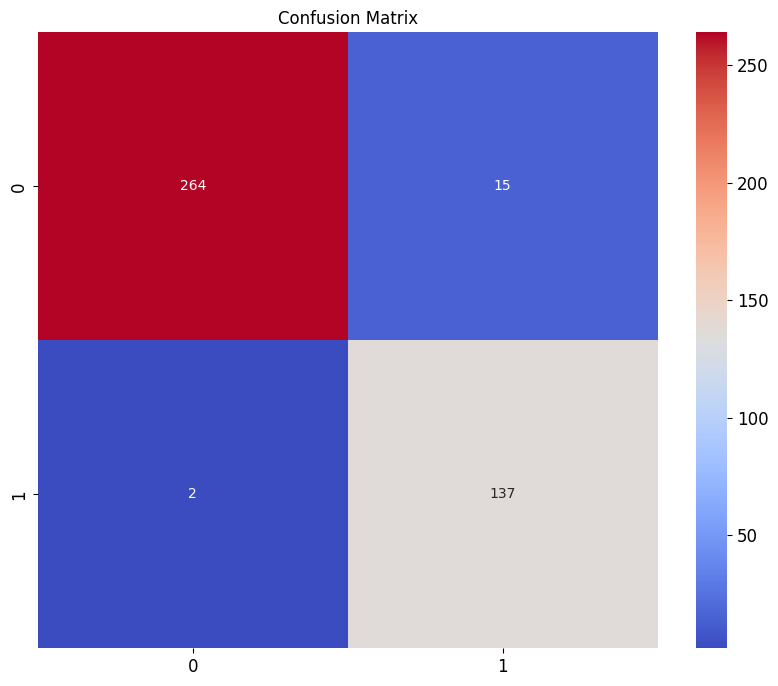

In [46]:
hard_voting_clf = VotingClassifier([
    #(etc.__class__.__name__, xgb),
    (svc.__class__.__name__, svc),
    (log_reg.__class__.__name__, log_reg)
], n_jobs=-1, voting="hard")

hrd_voting_train_acc, hrd_voting_test_acc = eval_(hard_voting_clf, X_train, y_train, X_test, y_test)

VotingClassifier
Accuracy scores mean = 0.819304152637486
Accuracy On Train set = 0.8327721661054994
Accuracy On Test set = 0.9521531100478469
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       272
           1       0.91      0.95      0.93       146

    accuracy                           0.95       418
   macro avg       0.94      0.95      0.95       418
weighted avg       0.95      0.95      0.95       418



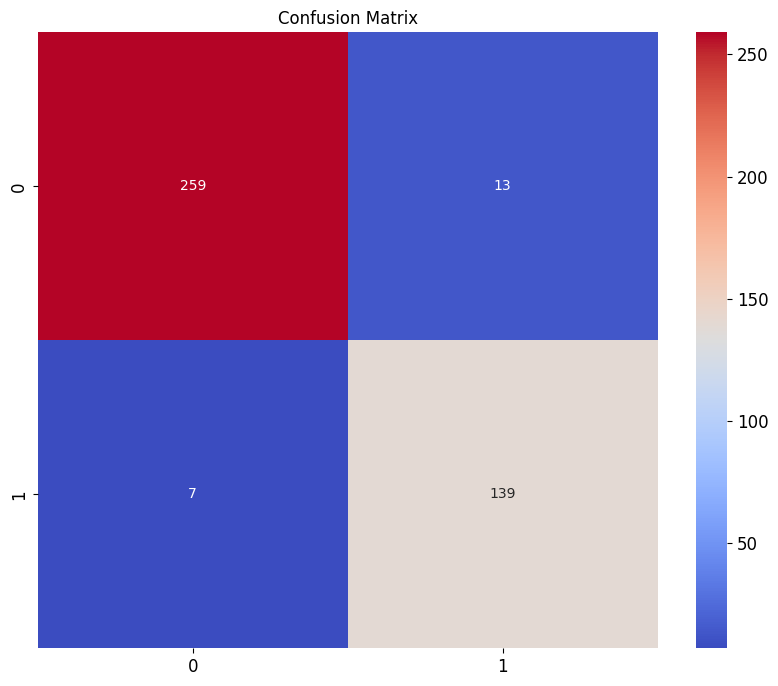

In [47]:
soft_voting_clf = VotingClassifier([
     #('knn', knn),
    #(etc.__class__.__name__, etc),
    (svc.__class__.__name__, svc),
    (log_reg.__class__.__name__, log_reg)
], n_jobs=-1, voting="soft")

sft_voting_train_acc, sft_voting_test_acc = eval_(soft_voting_clf, X_train, y_train, X_test, y_test)

In [48]:
pca = PCA(n_components= 0.95)
X_train_red = pca.fit_transform(X_train)
X_test_red = pca.transform(X_test)

In [49]:
pca.n_components_

7

In [50]:
X_train_red.shape, X_test_red.shape

((891, 7), (418, 7))

In [51]:
y_train.shape, y_test.shape

((891,), (418,))

RandomForestClassifier
Accuracy scores mean = 0.7856341189674523
Accuracy On Train set = 0.9775533108866442
Accuracy On Test set = 0.7751196172248804
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.81      0.83       278
           1       0.65      0.71      0.68       140

    accuracy                           0.78       418
   macro avg       0.75      0.76      0.75       418
weighted avg       0.78      0.78      0.78       418



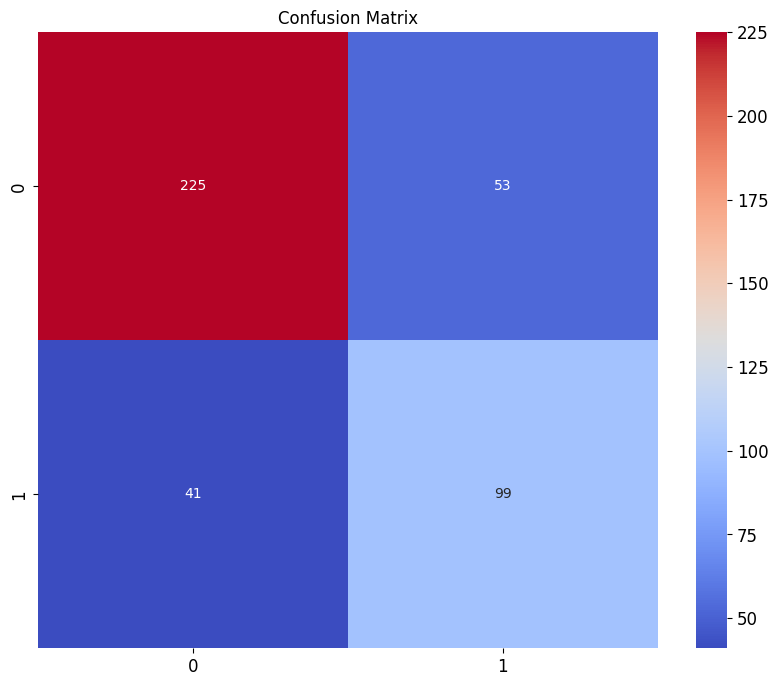

In [52]:
rnd_clf_2 = RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)

rnd_clf_2_tr_acc, rnd_clf_2_tst_acc = eval_(rnd_clf_2, X_train_red, y_train, X_test_red, y_test)

LogisticRegression
Accuracy scores mean = 0.797979797979798
Accuracy On Train set = 0.8058361391694725
Accuracy On Test set = 0.9425837320574163
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       266
           1       0.92      0.92      0.92       152

    accuracy                           0.94       418
   macro avg       0.94      0.94      0.94       418
weighted avg       0.94      0.94      0.94       418



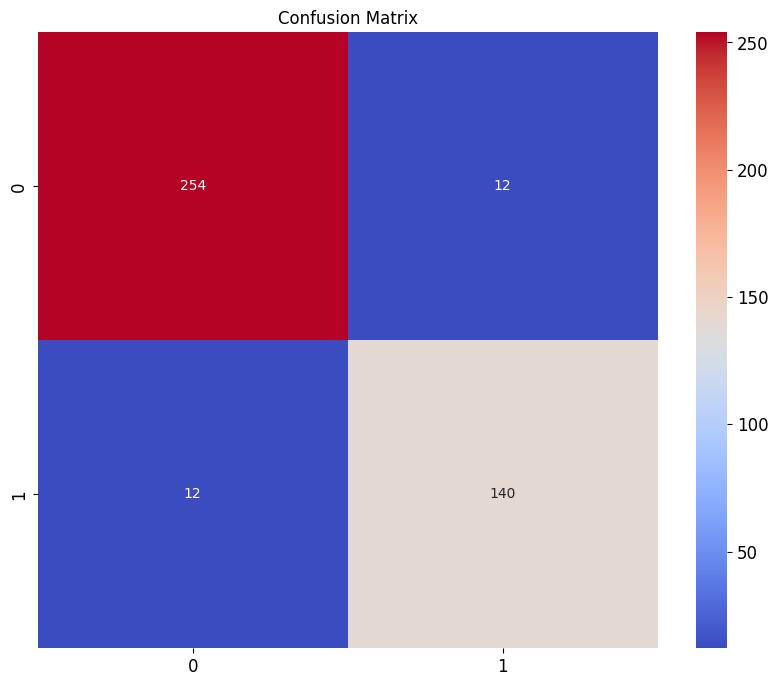

In [53]:
log_reg_2 = LogisticRegression(n_jobs=-1, random_state=42)

log_reg_2_tr_acc, log_reg_2_tst_acc = eval_(log_reg_2, X_train_red, y_train, X_test_red, y_test)

SVC
Accuracy scores mean = 0.8249158249158248
Accuracy On Train set = 0.8372615039281706
Accuracy On Test set = 0.9401913875598086
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       265
           1       0.92      0.92      0.92       153

    accuracy                           0.94       418
   macro avg       0.94      0.93      0.94       418
weighted avg       0.94      0.94      0.94       418



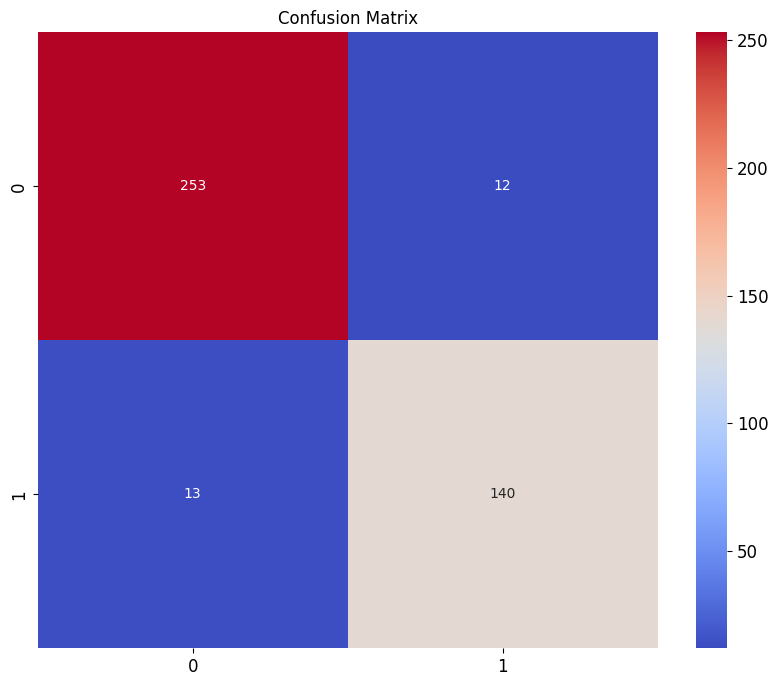

In [54]:
svc_2 = SVC()

svc_2_tr_acc, svc_2_tst_acc = eval_(svc_2, X_train_red, y_train, X_test_red, y_test)

# Results

In [55]:
first_scenario_results = [
        {'Model': rnd_clf.__class__.__name__, 'Train Accuracy': rnd_clf_train_acc , 'Test Accuracy': rnd_clf_test_acc},
    
        {'Model': dtc.__class__.__name__, 'Train Accuracy': dtc_train_acc , 'Test Accuracy': dtc_test_acc},
    
        {'Model': knn.__class__.__name__, 'Train Accuracy': knn_train_acc , 'Test Accuracy': knn_test_acc},
    
        {'Model': xgb.__class__.__name__, 'Train Accuracy': xgb_train_acc , 'Test Accuracy': xgb_test_acc},
    
        {'Model': svc.__class__.__name__, 'Train Accuracy': svc_train_acc , 'Test Accuracy': svc_test_acc},
    
        {'Model': log_reg.__class__.__name__, 'Train Accuracy': log_reg_train_acc , 'Test Accuracy': log_reg_test_acc},
]

first_scenario_results = pd.DataFrame(first_scenario_results).style.set_properties(**{'font-weight': 'bold'}, subset=pd.IndexSlice[[4,5], :])
print("Results before hyperparameters tuning : ")
print('-'*70)
first_scenario_results

Results before hyperparameters tuning : 
----------------------------------------------------------------------


,Model,Train Accuracy,Test Accuracy
0,RandomForestClassifier,0.977553,0.794258
1,DecisionTreeClassifier,0.977553,0.770335
2,KNeighborsClassifier,0.861953,0.846890
3,XGBClassifier,0.962963,0.813397
4,SVC,0.837262,0.940191
5,LogisticRegression,0.806958,0.944976


In [56]:
second_scenario_results = [
        {'Model': best_rnd_clf.__class__.__name__, 'Train Accuracy': best_rnd_train_acc , 'Test Accuracy': best_rnd_acc},
    
        {'Model': best_knn.__class__.__name__, 'Train Accuracy': best_knn_train_acc , 'Test Accuracy': best_knn_acc},
    
        {'Model': best_svc.__class__.__name__, 'Train Accuracy': best_svc_train_acc , 'Test Accuracy': best_svc_test_acc},
]

second_scenario_results = pd.DataFrame(second_scenario_results).style.set_properties(**{'font-weight': 'bold'}, subset=pd.IndexSlice[[2], :])
print("Results after hyperparameters tuning : ")
print('-'*70)
second_scenario_results

Results after hyperparameters tuning : 
----------------------------------------------------------------------


,Model,Train Accuracy,Test Accuracy
0,RandomForestClassifier,0.977553,0.794258
1,KNeighborsClassifier,0.861953,0.846890
2,SVC,0.837262,0.940191


In [57]:
third_scenario_results = [
        {'Model':hard_voting_clf.voting+" "+ hard_voting_clf.__class__.__name__, 'Train Accuracy': hrd_voting_train_acc , 'Test Accuracy': hrd_voting_test_acc},
    
        {'Model':soft_voting_clf.voting+" "+ soft_voting_clf.__class__.__name__, 'Train Accuracy': sft_voting_train_acc , 'Test Accuracy': sft_voting_test_acc}
]

third_scenario_results = pd.DataFrame(third_scenario_results).style.set_properties(**{'font-weight': 'bold'}, subset=pd.IndexSlice[[0], :])
print("Hard and Soft Voting : ")
print('-'*70)
third_scenario_results

Hard and Soft Voting : 
----------------------------------------------------------------------


,Model,Train Accuracy,Test Accuracy
0,hard VotingClassifier,0.823793,0.959330
1,soft VotingClassifier,0.832772,0.952153


In [58]:
fourth_scenario_results = [
        {'Model': rnd_clf_2.__class__.__name__, 'Train Accuracy': rnd_clf_2_tr_acc , 'Test Accuracy': rnd_clf_2_tst_acc},
    
        {'Model': log_reg_2.__class__.__name__, 'Train Accuracy': log_reg_2_tr_acc , 'Test Accuracy': log_reg_2_tst_acc},
    
        {'Model': svc_2.__class__.__name__, 'Train Accuracy': svc_2_tr_acc , 'Test Accuracy': svc_2_tst_acc}
]

fourth_scenario_results = pd.DataFrame(fourth_scenario_results).style.set_properties(**{'font-weight': 'bold'}, subset=pd.IndexSlice[[1,2], :])
print("After dimensionality reduction : ")
print('-'*70)
fourth_scenario_results

After dimensionality reduction : 
----------------------------------------------------------------------


,Model,Train Accuracy,Test Accuracy
0,RandomForestClassifier,0.977553,0.775120
1,LogisticRegression,0.805836,0.942584
2,SVC,0.837262,0.940191
